In [1]:
from qiskit import *
from math import pi
import numpy as np
from qiskit.aqua.operators import CircuitStateFn
from qiskit.aqua.operators.gradients import QFI
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from sklearn import datasets
import scipy
from qiskit import *
from math import pi
import math
import numpy as np
from qiskit.aqua.operators import CircuitStateFn
from qiskit.aqua.operators.gradients import QFI
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
import scipy
from sklearn import datasets
import time

In [2]:
iris = datasets.load_iris()
X = iris.data[:, :][0:100]
y = iris.target[0:100]

In [3]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [20]:
numQubits = 2
depthVariational = 9   ##using formula d = (D+1)*S, taking d = 40 and S = 4
d = 40

In [21]:
def make_feature_map(qf, data):
    for i in range(2):
        qf.h(i)
    qf.barrier()
    qf.rz(data[0], 0)
    qf.rz(data[2], 1)
    qf.ry(data[1], 0)
    qf.rz(data[3], 1)

In [22]:
def add_cnots(qf):
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qf.cx(i, j)
    qf.barrier()

def add_layerRY(qf):
    for qubit in range(numQubits):
        qf.ry(next(theta_iter), qubit)
    qf.barrier()

def make_variationalCircuit(qf):
    add_cnots(qf)
    add_layerRY(qf)

In [27]:
def make_final_circuit(qf, data, depth):
    make_feature_map(qf, data)
    #add_layerRY(qf)
    #for i in range(depth):
       # make_variationalCircuit(qf)

In [28]:
qf = QuantumCircuit(QuantumRegister(2))
params = ParameterVector('θ_', length = 20) 
theta_iter = iter(params)
make_final_circuit(qf, normalize(X[0]), 9)

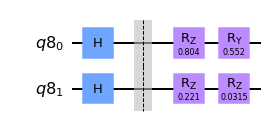

In [29]:
qf.draw('mpl')

In [31]:
all_eigenvals = []
fisher_matrices = []

In [32]:
for index in range(10):

    data = normalize(X[index])
    
    params = ParameterVector('θ_', length = d) 
    theta_iter = iter(params)
    print(params)
    qf = QuantumCircuit(QuantumRegister(numQubits))
    make_final_circuit(qf, data, depthVariational)
    
    state = CircuitStateFn(primitive=qf, coeff=1.)
    qfi = qiskit.aqua.operators.gradients.QFI(qfi_method='lin_comb_full').convert(operator=state, params=params.params)
    np.random.seed(0)
    values_dict = {params: np.random.uniform(-1, 1, d)} 
    qfi_result = qfi.assign_parameters(values_dict).eval()
    print(qfi_result)
    fisher_matrix = np.real(np.array(qfi_result))
    fisher_matrices.append(fisher_matrix)
    eigvals,eigvecs=scipy.linalg.eigh(fisher_matrix)
    print(eigvals)
    all_eigenvals.append(eigvals)